# Analysis of incomplete time series - Part 1

There are three types of time series:
* regular, complete time series
* regular but incomplete time series
* irregular time series

All of these require different analysis methods. 

We will first focus on regular but incomplete time series, and later move on to irregular time series.

## Example: Swinoujscie monthly sea level

The tide gauge in Swinoujscie has produced one of the longest sea level records worldwide, data on relative sea level exist from 1811 onwards. Such long time series are extremely valuable for attributing sea level rise to climate change.

Monthly sea level data from stations around the world can be downloaded from https://www.psmsl.org. 
For higher temporal resolution (e.g. for research on extreme sea levels), the first choice would be https://gesla.org/.

Let us plot the PSMSL data for Swinoujscie:
<div style="text-align: right"> <span style="color:red">replace %%%%%%%%%%</span></div>

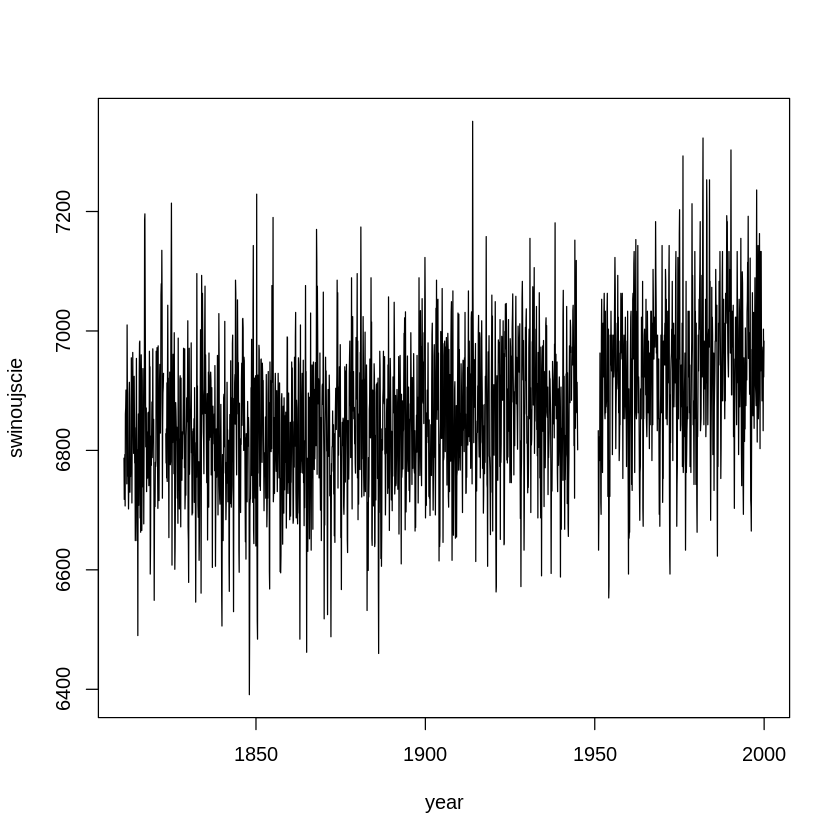

In [7]:
# read in Swinoujsce data
sldata = read.csv("../Data/sealevel/swinoujscie.rlrdata",sep = ";",header=FALSE)
# select first two columns only
sldata = sldata[,1:2]
colnames(sldata) = c("year","swinoujscie")
# set negative values to missing values
sldata$swinoujscie[sldata$swinoujscie<0]=NA
# plot the data
plot(sldata, type="l") 

We see that there is a larger gap starting during the second world war.

Assume we want to estimate the Fourier power spectrum of this time series in the 20th century.
Let's try it straightforward:
<div style="text-align: right"> <span style="color:red">replace %%%%%%%%%%</span></div>

In [9]:
# select 20th century only
sldata = sldata[(sldata$year>=1900) & (sldata$year<2000),]
# remove the temporal mean
sldata$swinoujscie = sldata$swinoujscie - mean(sldata$swinoujscie,na.rm=TRUE)
# try fft
spectrum = fft(sldata$swinoujscie)
print(spectrum[1:10])

 [1] NA NA NA NA NA NA NA NA NA NA


This didn't work: The FFT algorithm cannot handle missing values, so it gave only NA as output.

#### <span style="color:red">Here is what you should not do:</span>

We could try to set the missing values to zero and compute the spectrum:

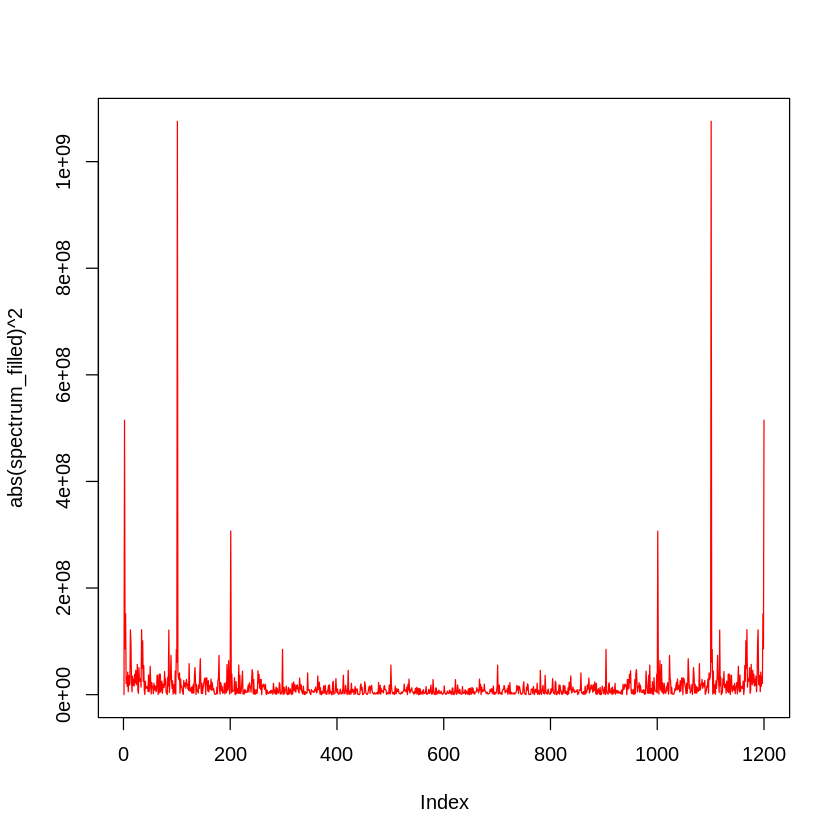

In [6]:
sldata_filled = sldata
sldata_filled$swinoujscie[is.na(sldata_filled$swinoujscie)] = 0
spectrum_filled = fft(sldata_filled$swinoujscie)
plot(abs(spectrum_filled)^2, type="l",col="red")

Our goal is to get a good estimate for the spectrum of the full time series without the gap.
The following study compared different methods for this purpose:

*[Babu, Prabhu. 2012. Spectral Analysis of Nonuniformly Sampled Data and Applications. Uppsala universitet. https://uu.diva-portal.org/smash/get/diva2:549963/FULLTEXT01.pdf]*

The IAA method (iterative adaptive approach) performed best results. This is the reference:

*[T. Yardibi, J. Li, P. Stoica, M. Xue,
and A. B. Baggeroer. Iterative
adaptive approach for sparse
signal representation with sensing
applications. IEEE Transactions on
Aerospace and Electronic
Systems, 2009, to appear.]*

but in fact it never appeared.
The following code implements the IAA algorithm which is described on page 34 of the Babu dissertation:

In [7]:
iaa = function(signal, steps=10) {
  # get length of time series
  M = length(signal)
  # check where data are present
  signal_present = is.finite(signal)
  N = sum(signal_present)
  # calculate times where data are present, assuming T=1
  times = (seq_len(M)-1)/M
  times = times[signal_present]
  values = signal[signal_present]
  # calculate Nyquist frequency 2*pi/T but T=1
  omega1 = 2*pi
  # for each frequency M, define a fourier vector based on the times
  a = matrix(0,nrow=N,ncol=M)
  for (j in seq_len(M)) {
    a[,j]=exp(1i*(j-1)*omega1*times)
  }
  # initialize R matrix with identity matrix
  R = diag(1,N)
  beta = rep(0,M)
  # now do the iteration loop
  for (i in seq_len(steps)) {
    print(paste0("iaa ",i,"/",steps))
    # calculate beta
    tempvec = solve(R,values)
    numerator = apply(Conj(a)*tempvec,2,sum)
    tempvec = solve(R,a)
    for (j in seq_len(M)) {
      denominator = sum(Conj(a[,j])*tempvec[,j])
      beta[j] = numerator[j]/denominator
    }
    # calculate R
    R = diag(0,N)
    for (j in seq_len(M)) {
      R = R + abs(beta[j])^2*a[,j]%*%t(Conj(a[,j]))
    }
  }
  return(beta*M)
}

The disadvantage is that it is rather slow (this one should take 5 minutes), so let us start it before we look at what it does.

In [ ]:
print("calculating ...")
spectrum = iaa(sldata$swinoujscie,steps = 5)
print("done.")

[1] "calculating ..."


### The Iterative Adaptive Approach

#### Discrete Fourier tranform

A discrete Fourier Transform of a vector $\mathbf{y}$ (of length $N$) can be described by the multiplication of the Fourier matrix:
$$ \tilde{\mathbf{y}} = \mathbf{F} \cdot \mathbf{y}$$
The Fourier matrix is defined as
$$ \mathbf{F} = \begin{pmatrix}  
1 & 1 & 1 & \dots & 1 \\
1 & \exp(i\omega_0t) & \exp(2i\omega_0t)& \dots & \exp((N-1)i\omega_0t) \\
1 & \exp(2i\omega_0t) & \exp(4i\omega_0t)& \dots & \exp(2(N-1)i\omega_0t) \\
\dots & \dots & \dots & & \dots \\
1 & \exp((N-1)i\omega_0t) & \exp(2(N-1)i\omega_0t)& \dots & \exp((N-1)^2i\omega_0t) 
\end{pmatrix} $$
with 
$$ \omega_0 = 2\pi/N $$
The inverse transformation is then simply
$$ \mathbf{y} = \mathbf{F}^{-1} \cdot \mathbf{\tilde{y}}$$

and the trick is that the inverse of the Fourier matrix can be easily calculated just from the complex conjugate:
$$ \mathbf{F}^{-1} = \frac{1}{N} \mathbf{F}^* = \begin{pmatrix}  
1 & 1 & 1 & \dots & 1 \\
1 & \exp(-i\omega_0t) & \exp(-2i\omega_0t)& \dots & \exp(-(N-1)i\omega_0t) \\
1 & \exp(-2i\omega_0t) & \exp(-4i\omega_0t)& \dots & \exp(-2(N-1)i\omega_0t) \\
\dots & \dots & \dots & & \dots \\
1 & \exp(-(N-1)i\omega_0t) & \exp(-2(N-1)i\omega_0t)& \dots & \exp(-(N-1)^2i\omega_0t) 
\end{pmatrix} $$

So, transforming back and forth gives the original vector:
$$ \mathbf{y} = \frac{1}{N} \mathbf{F}^* \cdot \mathbf{F} \cdot \mathbf{y}$$

#### Missing values in $\mathbf{y}$
When values in $y$ are missing, we can treat it as a shorter vector $\mathbf{y}'$ of length $<N$.
We can then remove some columns in the Fourier matrix and still calculate the spectrum of the full length $N$:
$$\tilde{\mathbf{y}}_{simple} = \mathbf{F}' \cdot \mathbf{y}'$$
This gives the same result as setting the missing values to zero.
If we try to back-transform, however, we do not succeed:
$$\mathbf{y}' \neq \frac{1}{N} \mathbf{F}'^T{}^* \cdot \mathbf{F}' \cdot \mathbf{y}'$$
(due to the matrix dimensions we need to transpose, which didn't matter before because $\mathbf{F}$ was symmetric)

#### The Vaniček method or Lomb-Scargle Periodogram
The idea is to correct for this mismatch.
We can calculate the matrix which causes the deviation beforehand:
$$\mathbf{R} =  \mathbf{F}'^T{}^* \cdot \mathbf{F}' $$
and then apply $\mathbf{R}^{-1}$ to $\mathbf{y}$ before calculating the spectrum:
$$\tilde{\mathbf{y}}_{LS} = \mathbf{F}' \cdot \mathbf{R}^{-1} \cdot \mathbf{y}'$$
The term $\tilde{\mathbf{y}}_{LS}$ is called the Lomb-Scargle Periodogram and is used in astronomy to precisely estimate cycle lengths.
The advantage is that we get the correct result if we back-transform:
$$\mathbf{y}' = \frac{1}{N} \mathbf{F}'^T{}^* \cdot \tilde{\mathbf{y}}_{LS} = \frac{1}{N} \mathbf{F}'^T{}^* \cdot \mathbf{F}' \cdot \mathbf{R}^{-1} \cdot \mathbf{y}'$$
The LS peridogram $\tilde{\mathbf{y}}_{LS}$ is already a better estimate for the full spectrum $\tilde{\mathbf{y}}$ of the complete time series than $\tilde{\mathbf{y}}_{simple}$, but we can do better.

#### The IAA method
The method aims at estimating a better repair matrix $\mathbf{\hat{R}}$.
We look at the single rows of the Fourier matrix. Let us define the row $k$ of the Fourier matrix $\mathbf{F}'$ as:
$$\mathbf{f}_k = \left(1, \exp(ki\omega_0 t), \exp(2ki\omega_0 t), \dots, \exp((N-1)ki\omega_0 t) \right)$$
Then the algorithm works iteratively.
* start with $\mathbf{\hat{R}}=\mathbf{I}$
* then repeat:
  * $\tilde{\mathbf{y}}_{IAA} \, := \, \frac{\mathbf{f}_k \cdot \mathbf{\hat{R}}^{-1} \cdot \mathbf{y}'}{\mathbf{f}_k \cdot \mathbf{R}^{-1} \cdot \mathbf{f}_k^*{}^T}$ (estimate the spectrum)
  * $\mathbf{\hat{R}} \, := \, \sum_k | \tilde{y}_{IAA,k} |^2  \mathbf{f}_k^*{}^T \cdot \mathbf{f}_k$ (based on the spectrum, modify the repair matrix)
  
It turns out that the estimated spectrum $\tilde{\mathbf{y}}_{IAA}$ is mostly a good approximate for the full spectrum $\tilde{\mathbf{y}}$.

Let us plot the spectrum now:

In [ ]:
plot(abs(spectrum)^2, type="l")
lines(abs(spectrum_filled)^2, col="red")

We can see different peaks in the spectrum. The peak at $n=100$ is e.g. the annual cycle, since the time series is 100 years long.

The simple method underestimates these peaks: In the gap where we filled in the zeros, the annual cycle is missing.

The IAA method instead practically fills the gap with values which fit to the rest of the spectrum. Let's see what happens if we back-transform it:
<div style="text-align: right"> <span style="color:red">replace %%%%%%%%%%</span></div>

In [ ]:
# reconstruct the spectrum
N=length(spectrum)
reconstruction = fft(spectrum,inverse=TRUE)/N
reconstruction = Re(reconstruction)
# plot the result and the original data
plot(sldata$year,reconstruction,col="green",type="l")
lines(%%%%%%%%%%,sldata$swinoujscie)

The green values shouldn't bee seen as a reconstruction of the missing data, though. 

The IAA method is also nice for complete but non-periodic time series to avoid the Fourier signal of the hard jump between beginning and end of the time series. Just add a few missing values after the time series to avoid this hard jump.

## Reconstruction of missing values by the help of proxy data

Sometimes proxy data can help to get an approximate value for the missing data, which is better than no information.
For example, other tide gauge stations in the Baltic Sea may be related to the one in Swinoujscie. Let us load data from some more tide gauges and put them into a matrix.
<div style="text-align: right"> <span style="color:red">replace %%%%%%%%%%</span></div>

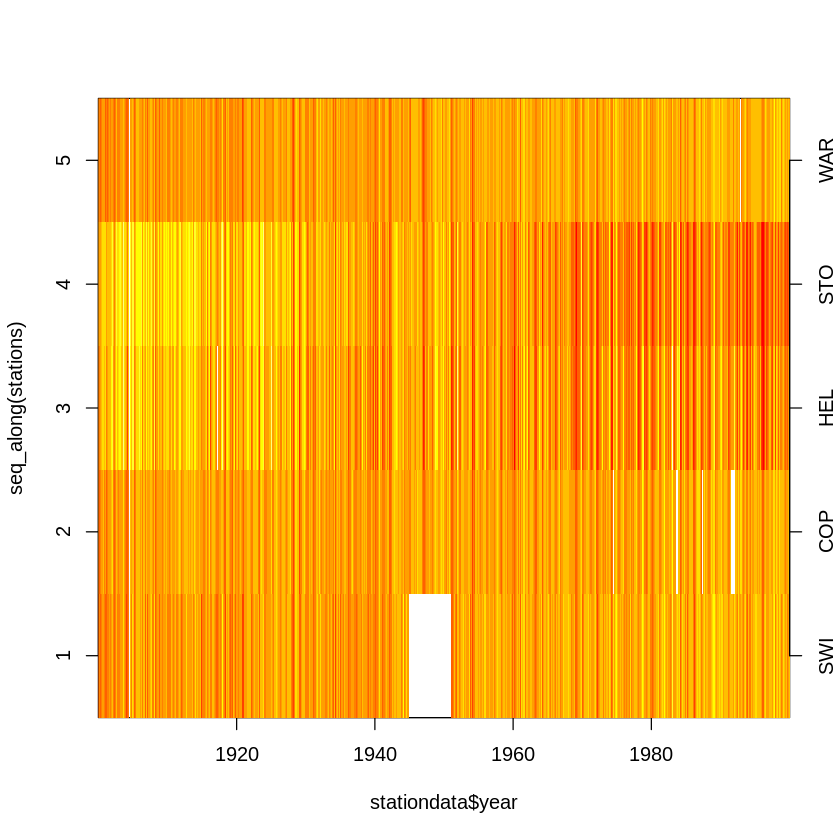

In [2]:
stations = c("swinoujscie","copenhagen","helsinki","stockholm","warnemuende")
# initialise a matrix with NA values
sl_matrix = matrix(NA,12*100,length(stations))
# loop over the stations
for (i in seq_along(stations)) {
    # read in the tide gauge data
    stationdata = read.csv(paste0("../Data/sealevel/",stations[i],".rlrdata"),sep = ";",header=FALSE)
    # select first two columns only
    stationdata = stationdata[,1:2]
    colnames(stationdata) = c("year","sealevel")
    # set negative values to missing values
    stationdata$sealevel[stationdata$sealevel <(-500)]=NA
    # select 20th century only
    stationdata = stationdata[(stationdata$year>=1900)&(stationdata$year<2000),]
    # remove the mean
    stationdata$sealevel = stationdata$sealevel - mean(stationdata$sealevel,na.rm=TRUE)
    # put the data into the matrix
    sl_matrix[,i] = stationdata$sealevel
}
# plot the data as a matrix
image(x=stationdata$year,y=seq_along(stations),z=sl_matrix)
# write station names to the right
axis(4,at = 1:5,labels=toupper(substr(stations,1,3)))


We see that there is some similarity between the stations which we could use to guess the Swinoujscie data.

There are plenty of ways to do this. Guessing data from proxy information is a huge topic in the field of artificial intelligence.

As an example, we use a nicely simple method: Data-interpolating EOFs (DINEOF). The method is described here:

*Beckers, J.M., Rixen, M., 2003. EOF Calculations and Data Filling from Incomplete Oceanographic Datasets. J. Atmos. Oceanic Technol. 20, 1839–1856. https://journals.ametsoc.org/doi/pdf/10.1175/1520-0426%282003%29020%3C1839%3AECADFF%3E2.0.CO%3B2*

### The DINEOF method

The method is rather simple:
* Use zero as initial guess for the data in the gaps
* Calculate the first EOF of the dataset
* Use the values of this EOF estimate as a better guess in the gaps
* Estimate the first EOF again, repeat this until first EOF converges

* Now continue with the second EOF etc: For each EOF we iterate and improve the estimates until it converges

* Our reconstruction for the data in the gaps are then the sum of $n$ EOFs.

Here is an implementation based on the **sinkr** R package:

In [3]:
dineof <- function(Xo, n.max=NULL, ref.pos=NULL, delta.rms=1e-5, method="svd", speed=1, replace_ref=TRUE, punish_large_guesses=0){
  
  if(is.null(n.max)){
    n.max=dim(Xo)[2]
  }	
  
  na.true <- which(is.na(Xo))
  na.false <- which(!is.na(Xo))
  if(is.null(ref.pos)) ref.pos <- sample(na.false, max(30, 0.01*length(na.false)))
  
  Xa <- replace(Xo, na.true, 0)
  if (replace_ref) {Xa <- replace(Xa, ref.pos, 0)}
  rms.prev <- Inf
  rms.now <- sqrt(mean(Xo[ref.pos]^2))
  n.eof <- 1
  RMS <- rms.now
  NEOF <- n.eof
  Xa.best <- Xa
  n.eof.best <- n.eof	
  while(rms.prev - rms.now > delta.rms & n.max > n.eof){ #loop for increasing number of EOFs
    while((rms.prev - rms.now > delta.rms)){ #loop for EOF refinement
      rms.prev <- rms.now
      if(method == "irlba"){
        SVDi <- irlba::irlba(Xa, nu=n.eof, nv=n.eof)	  
      }
      if(method == "svd"){
        SVDi <- svd(Xa)	  
      }
      if(method == "svds"){
        SVDi <- RSpectra::svds(Xa, k=n.eof)	  
      }
      RECi <- as.matrix(SVDi$u[,seq(n.eof)]) %*% as.matrix(diag(SVDi$d[seq(n.eof)], n.eof, n.eof)) %*% t(as.matrix(SVDi$v[,seq(n.eof)]))
      Xa[na.true] <- RECi[na.true]*speed+Xa[na.true]*(1-speed)
      if (replace_ref) {
        Xa[ref.pos] <- RECi[ref.pos]*speed+Xa[ref.pos]*(1-speed)
      }
      rms.now <- sqrt(mean(c((RECi[ref.pos] - Xo[ref.pos])^2,punish_large_guesses*RECi[na.true]^2)))
      print(paste(n.eof, "EOF", "; RMS =", round(rms.now, 8)))
      RMS <- c(RMS, rms.now)
      NEOF <- c(NEOF, n.eof)
      gc()
      if(rms.now == min(RMS)) {
        Xa.best <- Xa
        n.eof.best <- n.eof
      }
    }
    # Add EOF and check for improvement
    n.eof <- n.eof + 1
    rms.prev <- rms.now
    if(method == "irlba"){
      SVDi <- irlba::irlba(Xa, nu=n.eof, nv=n.eof)	  
    }
    if(method == "svd"){
      SVDi <- svd(Xa)	  
    }
    if(method == "svds"){
      SVDi <- RSpectra::svds(Xa, k=n.eof)	  
    }
    RECi <- as.matrix(SVDi$u[,seq(n.eof)]) %*% as.matrix(diag(SVDi$d[seq(n.eof)], n.eof, n.eof)) %*% t(as.matrix(SVDi$v[,seq(n.eof)]))
    Xa[na.true] <- RECi[na.true]*speed+Xa[na.true]*(1-speed)
    if (replace_ref) {
      Xa[ref.pos] <- RECi[ref.pos]*speed+Xa[ref.pos]*(1-speed)
    }
    rms.now <- sqrt(mean(c((RECi[ref.pos] - Xo[ref.pos])^2,punish_large_guesses*RECi[na.true]^2)))
    print(paste(n.eof, "EOF", "; RMS =", round(rms.now, 8)))
    RMS <- c(RMS, rms.now)
    NEOF <- c(NEOF, n.eof)
    gc()
    if(rms.now == min(RMS)) {
      Xa.best <- Xa
      n.eof.best <- n.eof
    }
  }
  
  Xa <- Xa.best
  n.eof <- n.eof.best
  rm(list=c("Xa.best", "n.eof.best", "SVDi", "RECi"))
  
  Xa[ref.pos] <- Xo[ref.pos]
  
  RESULT <- list(
    Xa=Xa, n.eof=n.eof, RMS=RMS, NEOF=NEOF, ref.pos=ref.pos
  )
  
  RESULT
}

Let's try the method for our sea level matrix. Say we want 3 EOFs for reconstruction.
<div style="text-align: right"> <span style="color:red">replace %%%%%%%%%%</span></div>

In [4]:
reconstruction = dineof(sl_matrix, n.max = 3)

[1] "1 EOF ; RMS = 64.85102755"
[1] "1 EOF ; RMS = 57.62949598"
[1] "1 EOF ; RMS = 56.65424988"
[1] "1 EOF ; RMS = 56.58796014"
[1] "1 EOF ; RMS = 56.6162229"
[1] "2 EOF ; RMS = 36.53285495"
[1] "2 EOF ; RMS = 31.80706663"
[1] "2 EOF ; RMS = 30.73964318"
[1] "2 EOF ; RMS = 30.53302434"
[1] "2 EOF ; RMS = 30.52945659"
[1] "2 EOF ; RMS = 30.56539235"
[1] "3 EOF ; RMS = 27.92060628"


The output gives an estimate for the error of the reconstruction. To get this estimate, 1% of the data have been randomly removed (artificial gaps), and we see how well they could be estimated.

Please note: This may change depending on the random position of the gaps, also influencing the result.

Let's plot the reconstructed matrix:

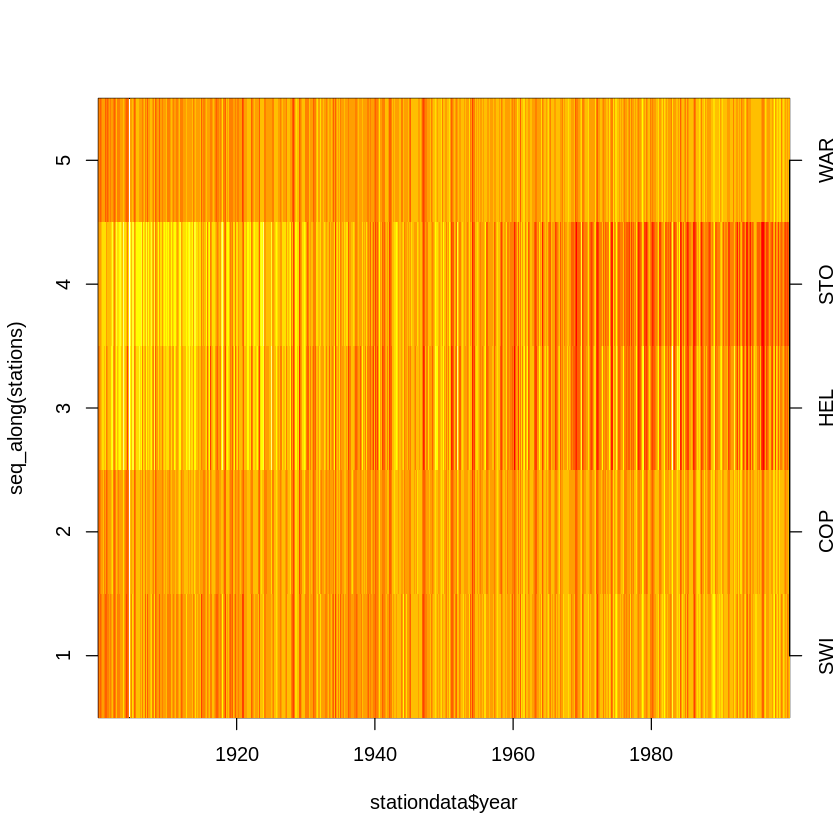

In [5]:
image(x=stationdata$year,y=seq_along(stations),z=reconstruction$Xa)
axis(4,at = 1:5,labels=toupper(substr(stations,1,3)))

And now we plot the estimated time series with uncertainty estimate:
<div style="text-align: right"> <span style="color:red">replace %%%%%%%%%%</span></div>

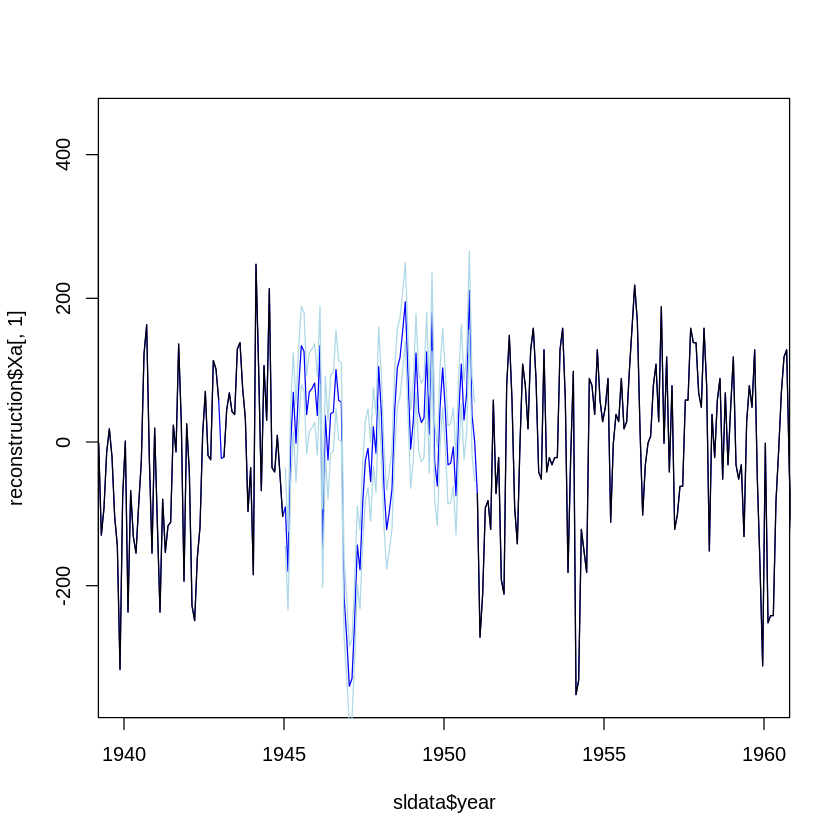

In [10]:
# plot reconstruction by first three EOFs in blue
plot(sldata$year,reconstruction$Xa[,1],type="l",col="blue",xlim=c(1940,1960))
# plot original data in black
lines(sldata$year,sldata$swinoujscie,col="black")
# get root mean squared error after last iteration
rms = reconstruction$RMS[length(reconstruction$RMS)]
# get locations of missing values
missing = is.na(sldata$swinoujscie)
# calculate upper range
upper_range = sldata$swinoujscie*NA
upper_range[missing]=reconstruction$Xa[missing,1]+1.96*rms
# calculate lower range
lower_range = sldata$swinoujscie*NA
lower_range[missing]=reconstruction$Xa[missing,1]-1.96*rms
# plot these
lines(sldata$year,upper_range,col="lightblue")
lines(sldata$year,lower_range,col="lightblue")

To accurately treat certain and uncertain data together, you might use a method such as that by Stedinger and Tasker 

*[Stedinger, J.R., Tasker, G.D., 1985. Regional Hydrologic Analysis: 1. Ordinary, Weighted, and Generalized Least Squares Compared. Water Resour. Res. 21, 1421–1432. https://doi.org/10.1029/WR021i009p01421 ]*

*[Stedinger, J.R., Tasker, G.D., 1986. Regional Hydrologic Analysis, 2, Model-Error Estimators, Estimation of Sigma and Log-Pearson Type 3 Distributions. Water Resour. Res. 22, 1487–1499. https://doi.org/10.1029/WR022i010p01487
]*


which considers both data errors and model errors.